<a href="https://colab.research.google.com/github/stevenfox/Pyspark_Nuclear_Classification/blob/master/Task_2_Distributed_Models_Spark_Nuclear_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: Develop distributed models in Apache spark to classify nuclear reactors

The objective of this assessment is to analyse a large dataset concerning pressurised water reactor data, specifically on the properties involved in the fuel assemblies cluster vibrations, alterations of thermal and hydraulic parameters, etc. 

For over 70 years, the nuclear power industry – in the UK and worldwide – have primarily focused on the technological evolution of reliable nuclear power plants to produce electricity. 
By monitoring pressurised water reactors (a type of nuclear reactor), whilst operating at nominal conditions, it is possible to collect valuable insight and extract knowledge for early detection of abnormal events. Various types of fluctuations and perturbations can be caused by the turbulent nature of flow in the core, mechanical vibrations within the reactor, the boiling coolant and stochastic character (random noise). The dataset can be downloaded from MyAberdeen.

It is based on data from a research project that investigates how to detect anomalies and events in pressurised water reactors. The dataset includes two classes (normal/abnormal condition) and a number of features, which will need to be utilised throughout this assessment.  The class membership of each row is stored in the field ‘Status’. 

The task is to develop a set of classification models for automatically **classifying reactors** as normal or abnormal, based on their parameters/features. No prior knowledge of the domain problem is needed.

##1. Create Apache Spark Cluster Environment 
importing and installing  all the required files

In [43]:
import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       
install_java()

openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)


In [0]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

In [0]:
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [0]:
!pip install -q findspark

In [0]:
import os
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

##1.1 Various Statistics on Dataset

In [49]:
#read the file using spark read command
file_loc = 'dataset.csv'
data = spark.read.csv(file_loc, inferSchema=True, header=True)

# print out the schema
data.printSchema()


root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3 : double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure _sensor_1: double (nullable = true)
 |-- Pressure _sensor_2: double (nullable = true)
 |-- Pressure _sensor_3: double (nullable = true)
 |-- Pressure _sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [50]:
# show the shape of the dataset
data.count(), len(data.columns)

(996, 13)

In [51]:
data.show(5)

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

In [0]:
def remove_whitespace(data, _col):
  temp = colm.replace(" ", "")
  data = data.withColumnRenamed(_col , temp)
  return data

In [0]:
for colm in data.columns:
  data = remove_whitespace(data, colm)  

In [54]:
data.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3: double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure_sensor_1: double (nullable = true)
 |-- Pressure_sensor_2: double (nullable = true)
 |-- Pressure_sensor_3: double (nullable = true)
 |-- Pressure_sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [55]:
data_features = data.drop("Status")
data_features.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4| Pressure_sensor_1| Pressure_sensor_2| Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|                 996|                 996|                 996|                 996|               996|               996|               996|              996|               996|               996|               996|               996|
|   mean|  4.9995738

In [56]:
data_features.printSchema()

root
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3: double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure_sensor_1: double (nullable = true)
 |-- Pressure_sensor_2: double (nullable = true)
 |-- Pressure_sensor_3: double (nullable = true)
 |-- Pressure_sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [0]:
from pyspark.sql.functions import col

def calc_quantile(_data, _col, quantile_prob):
  
  """
  Function that calculates the Quantile of the given probability

  Parameters: 
              _data: dataset
              _col: column
              quantile_prob: quantile probability
  Returns: 
          The approximate quantiles at the given probabilities.
  """
  return _data.approxQuantile(_col, [quantile_prob], 0.0)


In [0]:
def show_table_in_same_order(_prime, _target):

  """
  Function that rearranges the _prime dataframe's columns position(and types)
  in such a way that aligns with the order of the _target dataframe's 
  columns position.

  Parameters: 
              _prime: dataframe that is going to be rearranged
              _target: dataframe of which is going to have the same order

  Returns: Rearranged dataframe

  """
  rearranged_df = _prime.select(
      *(
          [
              col(t).cast(d) if t in _prime.columns else lit(None).alias(t) 
              for t, d in _target.dtypes
          ] +
          [s for s in _prime.columns if s not in _target.columns]
      )
  )


  rearranged_df.show()
  return rearranged_df


### Creating Quantile Tables using PySpark
Pyspark method `describe()` provides with the general statistical measures of **count**, **mean**, **stddev**, **min** and **max**. However, is not providing the quantiles of **25%** ,**50%**, and **75%** as the pandas does. 

Taking this into account and in the direction of **using PySpark instead of Pandas Dataframe** for this task, it is essential to calculate the quantiles of each column and create the table by ourselves. 

The snippet below, calculates for each column the quantiles of **25%** ,**50%**, and **75%** and stores them to three list respectively. Futhermore, it creates dictionary for every list and along with the column name in the form of `key/value` pair, for instance `{Summary: 25%}`. Hence, once the dictionaries are created, they are parallelised to form an RDD. 
Subsequently, it loads these three RDDs and creates three dataframes accordingly.

Lastly, it unites the three tables with each other maintaining the same order and it passes that table to `show_table_in_same_order` function to conform the order with the `data_feature` dataframe **columns**.

In [59]:
import string
from pyspark.sql.functions import *
from pyspark.sql.types import StringType

spark = SparkSession.builder.appName('abc').enableHiveSupport().getOrCreate()
sc = spark.sparkContext

# Quantile probabilities
probabilities = [0.25, 0.50, 0.75]

# Lists with the quantile values
quantile_25 = []
quantile_50 = []
quantile_75 = []

# The dataset with only the metrics from the features
data_f_stats = data_features.describe()
# The columns from the dataset with the features
cols_data_f_stats = data_f_stats.columns

# Calculate each column the quantiles for the probabilites [0.25, 0.50, 0.75]
for colm in data_features.columns:
    quantile_25.append(calc_quantile(data_features, colm, probabilities[0]))

for colm in data_features.columns:
    quantile_50.append(calc_quantile(data_features, colm, probabilities[1]))

for colm in data_features.columns:
    quantile_75.append(calc_quantile(data_features, colm, probabilities[2]))

# Add extra column with the quantile metric
quantile_25.insert(0,'25%')
quantile_50.insert(0,'50%')
quantile_75.insert(0,'75%')

# Dictionaries for the quantiles along with the column names
dic_25 = {}
dic_50 = {}
dic_75 = {}
i=0
# Update the dictionaries for each column with the calculated quantile value
for col_names in cols_data_f_stats:
    dic_25.update({col_names: quantile_25[i]})
    dic_50.update({col_names: quantile_50[i]})
    dic_75.update({col_names: quantile_75[i]})
    i+=1

# Parallelise the dictionaries respectively to form RDD
rdd_25 = sc.parallelize([dic_25])
# Load the RDD's and create the dataframes accordingly.
q_25 = spark.read.json(rdd_25)


rdd_50 = sc.parallelize([dic_50])
q_50 = spark.read.json(rdd_50)

rdd_75 = sc.parallelize([dic_75])
q_75 = spark.read.json(rdd_75)

# Unite the dataframes in pursuit of having a united 
#dataframe comprised of three metrics 
dq = q_25.union(q_50)
dq_all = dq.union(q_75)


# Display the statistical metrics of dataset with features only 
data_f_stats.show() 
# conforms with the order of data_f_stats and display the quantiles of the dataset 
show_table_in_same_order(dq_all, data_f_stats)




+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4| Pressure_sensor_1| Pressure_sensor_2| Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|                 996|                 996|                 996|                 996|               996|               996|               996|              996|               996|               996|               996|               996|
|   mean|  4.9995738

DataFrame[summary: string, Power_range_sensor_1: string, Power_range_sensor_2: string, Power_range_sensor_3: string, Power_range_sensor_4: string, Pressure_sensor_1: string, Pressure_sensor_2: string, Pressure_sensor_3: string, Pressure_sensor_4: string, Vibration_sensor_1: string, Vibration_sensor_2: string, Vibration_sensor_3: string, Vibration_sensor_4: string]

In [60]:
data_features.printSchema()

root
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3: double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure_sensor_1: double (nullable = true)
 |-- Pressure_sensor_2: double (nullable = true)
 |-- Pressure_sensor_3: double (nullable = true)
 |-- Pressure_sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [61]:
# Count of missing values of dataframe

data_features.select([count(when(isnan(c), c)).alias(c) for c in data_features.columns]).show()

+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4|Pressure_sensor_1|Pressure_sensor_2|Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|                   0|                   0|                   0|                   0|                0|                0|                0|                0|                 0|                 0|                 0|                 0|
+--------------------+--------------------+--------------------+

##2. Visualisation


###2.1 Box Plot

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
data_df = data.toPandas()

In [63]:
# Display the number of Status for each state
data.groupBy("Status").count().show()

+--------+-----+
|  Status|count|
+--------+-----+
|Abnormal|  498|
|  Normal|  498|
+--------+-----+



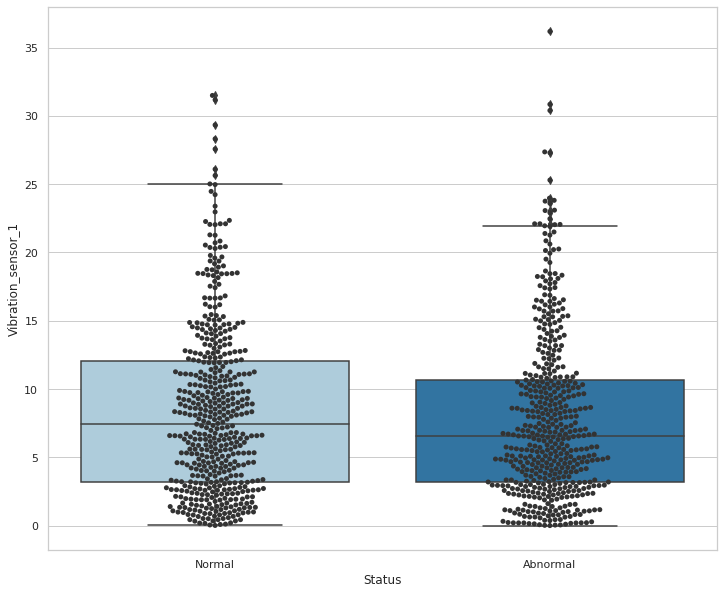

In [64]:
#plot box plot

sns.set(style='whitegrid', palette="Paired", font_scale=1, rc={"figure.figsize": [12, 10]})
ax = sns.boxplot(x="Status", y="Vibration_sensor_1", data=data_df, dodge=False)
ax = sns.swarmplot(x="Status", y="Vibration_sensor_1", data=data_df, color=".2")
plt.show()

###2.2 Distribution Plot

In [0]:
# Filter values
normal_status = data_df[data_df['Status'] == 'Normal']
abnormal_status = data_df[data_df['Status'] == 'Abnormal']

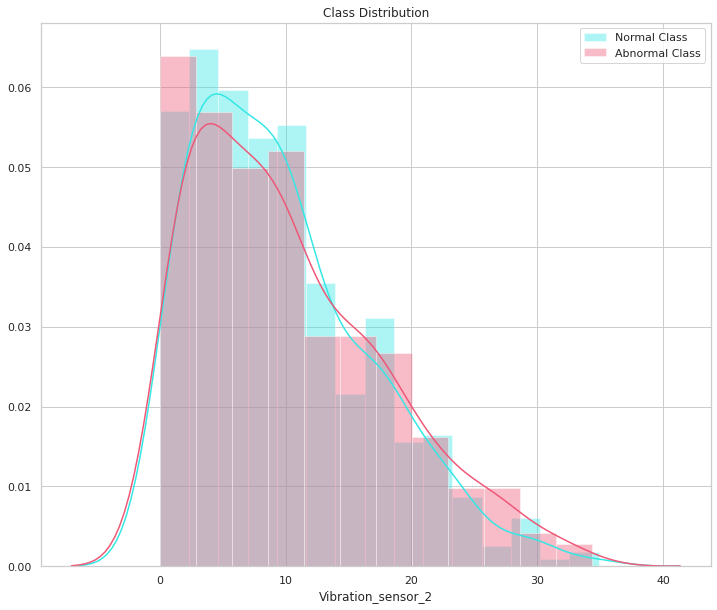

In [66]:
# Plot values distribution 

sns.set(style='whitegrid', font_scale=1, rc={"figure.figsize": [12, 10]})
dist_plot_color_set = ["#34e7e4","#ef5777"]
sns.set_palette(dist_plot_color_set)
sns.distplot(normal_status['Vibration_sensor_2'], label='Normal Class').set_title('Class Distribution')
sns.distplot(abnormal_status['Vibration_sensor_2'], label='Abnormal Class')
plt.legend()
plt.show()

#3. Logistic regression classification

Develop and train a binary logistic regression model to classify the condition of nuclear reactors, i.e. normal or abnormal, based on their operatation. 
Furthermore, perform split to the provided dataset into training (75%) and test (25%) sets.


In [0]:
# import all the required libraries for preparing and classifying the dataset 
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.sql.types import *

In [68]:
# Encode the string column of Status to a column of label indices

index_ = StringIndexer(inputCol="Status", outputCol="label")
data = index_.fit(data).transform(data)
data = data.withColumn("label", data["label"].cast(IntegerType()))
data = data.drop("Status")

data.show(5)

+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----+
|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4|Pressure_sensor_1|Pressure_sensor_2|Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|label|
+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----+
|              4.5044|              0.7443|                6.34|              1.9052|          29.5315|           0.8647|           2.2044|            6.048|           14.4659|            21.648|           15.3429|            1.2186|    0|
|              4.4284|              0.90

In [0]:
# scaling / standardizing features to help convergence of the two models for optimization

#combine all feautures into a single feature vector namely features
vec_assembler = VectorAssembler(inputCols=data.columns[1:-1],
                            outputCol="features")
#therefore we use that single vector features to predict the Status
predictors = vec_assembler.transform(data)
# normalise features with stddev 
std_scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
predictors = std_scaler.fit(predictors).transform(predictors)


In [70]:
#create the model data with those scaled features
model_data = predictors.select("scaled_features", "label")
model_data.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|scaled_features                                                                                                                                                                                                    |label|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[0.3218498836751728,2.5037784832143863,0.43749645121071834,2.528372025260846,0.40670884635362786,0.8726372195279792,1.4519300446321306,2.3433156436349054,2.9508333396982045,1.2617905837428387,0.167335327638901] |0    |
|[0.3923342730867718,2.228639292480086,0.3727399955937634,2.354716878084557,0.6915978809741811,0.7889124999080519,1.4369

### Create Split of training and testing set

In [0]:
train_data, test_data = model_data.randomSplit([.75,.25], seed=36)

In [87]:
print("Number of observations in training set: " + str(train_data.count()))
print("Number of observations in test set: " + str(test_data.count()))

Number of observations in training set: 759
Number of observations in test set: 237


In [0]:
from pyspark.ml.classification import LogisticRegression

In [0]:
# Logistic Regression

"""
Hyper-Parameters: 
                  maxIter = 17
                  From a various testings we performed on this model 
                  we observed that the value '17' maximises the overall
                  score of the model.

                  elasticNetParam = 0.5
                  From a various testings we performed on this model 
                  we observed that the value '0.5' regularisation
                  maximises the overall score of the model slightly while 
                  greater or lower values evidences no significant difference.

                  The rest of the hyper-parameters are set by the default configuration
                  which drives to more general use of the model.
"""

lr = LogisticRegression(featuresCol="scaled_features", labelCol="label", maxIter=17, elasticNetParam=0.5)
lrModel = lr.fit(train_data)

#4. Report the performance of the logistic regression model


Precision/Recall, Accuracy and Area under the curve (AUROC)

In [0]:
# import ml libraries for evaluation and metrics tools

from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [0]:
def print_model_performance(_train, _test, _model):

  """
  Function that prints out the metrics from the model evaluation 
  for both training and testing predictions. It returns sensible information
  that can be used for futher analysis in regards to the evaluation.

  Parameters: 
              _train: training set
              _test: testing set
              _model: machine learning model (either Linear Regression or Gradient-boosting tree )
  Returns:
          In Case of Linear Regression: model training summary
          In Case of Gradient-boosting tree: model predictions on testing set            

  """

  print('_Model Id: ',_model.uid)

  _model_train_predictions = _model.transform(_train)
  _model_test_predictions = _model.transform(_test)

  # Metrics for the evaluation in Precision/Recall, Accuracy and Area under the curve (AUROC)
  auc_eval = BinaryClassificationEvaluator(metricName='areaUnderROC', labelCol='label')
  acc_eval = MulticlassClassificationEvaluator(metricName='accuracy', labelCol='label')
  precision_eval = MulticlassClassificationEvaluator(metricName='weightedPrecision', labelCol='label')
  recall_eval = MulticlassClassificationEvaluator(metricName='weightedRecall', labelCol='label')

  print('- - -- - - - - - -- - - - - - - - - - - - - - - - - - -- - - - - - - - - -- -')
  print('- - -- - - - - - -- - - -  Performance Metrics - - - - - - -- - - - - -- -- -\n')
  print('Training set AUC: ' + str(auc_eval.evaluate(_model_train_predictions)))
  print('Training set Precision:' + str(precision_eval.evaluate(_model_train_predictions)))
  print('Training set Recall:' + str(recall_eval.evaluate(_model_train_predictions)))
  print('Training set Accuracy: ' + str(acc_eval.evaluate(_model_train_predictions)))

  print('- - -- - - - - - -- - - - - - - - - - - - - - - - - - -- - - - - - - - - -- -')
  print('Test set AUC: ' + str(auc_eval.evaluate(_model_test_predictions)))
  print('Test set Precision:' + str(precision_eval.evaluate(_model_test_predictions)))
  print('Test set Recall:' + str(recall_eval.evaluate(_model_test_predictions)))
  print('Test set Accuracy:' + str(acc_eval.evaluate(_model_test_predictions)))
  print('\n- - -- - - - - - -- - - - - - - - - - - - - - - - - - -- - - - - - - - - -- -')


  return _model.summary if 'LogisticRegression' in _model.uid else _model_test_predictions

In [122]:
training_summary = print_model_performance(train_data, test_data, lrModel)

_Model Id:  LogisticRegression_e2b2de2107c8
- - -- - - - - - -- - - - - - - - - - - - - - - - - - -- - - - - - - - - -- -
- - -- - - - - - -- - - -  Performance Metrics - - - - - - -- - - - - -- -- -

Training set AUC: 0.7978646499471727
Training set Precision:0.7179509029987412
Training set Recall:0.7180500658761528
Training set Accuracy: 0.7180500658761528
- - -- - - - - - -- - - - - - - - - - - - - - - - - - -- - - - - - - - - -- -
Test set AUC: 0.7743050554515342
Test set Precision:0.7319957805907173
Test set Recall:0.729957805907173
Test set Accuracy:0.729957805907173

- - -- - - - - - -- - - - - - - - - - - - - - - - - - -- - - - - - - - - -- -


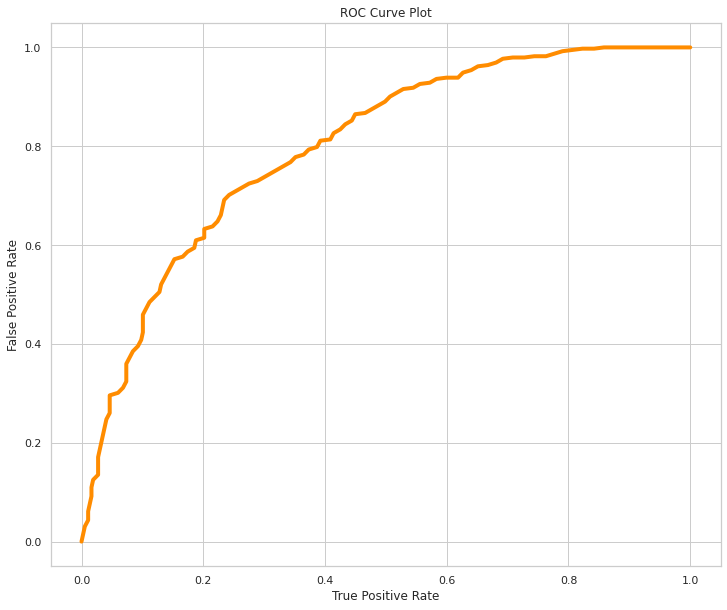

In [77]:
# Draw a Receiver Operating Characteristic Plot

roc = training_summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'], color='darkorange', linewidth=4, label='ROC Curve')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve Plot')
plt.show()

#5. Gradient-boosting tree classification

In this section, we are going to use an additional machine learning technique, **Gradient-boosting tree** to classify the condition of nuclear reactors.


In [0]:
# import GBT Classifier ML library

from pyspark.ml.classification import GBTClassifier

In [0]:
# Gradient-boosting tree model

"""
Hyper-Parameters: 
                  maxIter = 30
                  From a various testings we performed on this model 
                  we observed that the value '30' maximises the overall
                  score of the model.

                  maxDepth = 3
                  From a various testings we performed on this model 
                  we observed that the value '3' maximises the overall
                  score of the model while greater values evidences to overfitting.

                  stepSize = 0.3
                  From a various testings we performed on this model 
                  we observed that the value '0.3' for each iteration of optimisation
                  maximises the overall score of the model while greater values evidences 
                  to overfitting.

                  The rest of the hyper-parameters are set by the default configuration
                  which drives to more general use of the model.
"""

gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=30, maxDepth=3, stepSize=0.3)
gbt_model = gbt.fit(train_data)

#6. Report the performance of the Logistic Regression model 
Additionaly in this section, we evaluate the performance of the **Gradient-boosting tree model** , same as in section 4 for the logistic regression approach. 

In [110]:
test_predictions = print_model_performance(train_data, test_data, gbt_model)

_Model Id:  GBTClassifier_0fd1897305e7
- - -- - - - - - -- - - - - - - - - - - - - - - - - - -- - - - - - - - - -- -
- - -- - - - - - -- - - -  Performance Metrics - - - - - - -- - - - - -- -- -

Training set AUC: 0.9996594005449592
Training set Precision:0.9907799491379932
Training set Recall:0.9907773386034255
Training set Accuracy: 0.9907773386034255
- - -- - - - - - -- - - - - - - - - - - - - - - - - - -- - - - - - - - - -- -
Test set AUC: 0.9166786691631851
Test set Precision:0.844523296268339
Test set Recall:0.8438818565400844
Test set Accuracy:0.8438818565400844

- - -- - - - - - -- - - - - - - - - - - - - - - - - - -- - - - - - - - - -- -


The following table displays the predictions of the **Gradient-boosting tree model** on testing set. The first two columns `scaled_features` and `label` indicate the data set before is fitted into the model. 
Furthermore, `rawPrediction` column illustrates the measure of confidence in eash possible label. The larger value it is, the stronger confidence it has. 
Lastly the `probability` column denotes the outcome of applying the logistic function to `rawPrediction` column where the `prediction` column presents the maximum probability value from the `propability` column(array), in other words the predicted label.  

In [99]:
test_predictions.show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------+-----------------------------------------+----------+
|scaled_features                                                                                                                                                                                                       |label|rawPrediction                           |probability                              |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------+-----------------------------------------+----------+
|[0.16825445349725882,2.2301004881248643,0.516765

In [100]:
# Truncated view of the table above

test_predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|     scaled_features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.16825445349725...|    1|[-1.7614376730515...|[0.02866831915107...|       1.0|
|[0.22407981958951...|    0|[-1.7975961217842...|[0.02672174813844...|       1.0|
|[0.23514976050323...|    0|[1.18993003615612...|[0.91527858438948...|       0.0|
|[0.25850041711812...|    0|[1.36409447986899...|[0.93866966032324...|       0.0|
|[0.33175229175815...|    1|[-0.8630743390577...|[0.15108086923735...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



# Conclusion

In this task we saw two machine learning models using **pySpark** to classify the conditions of the **nuclear reactor**. Also, we observed what **accuracy precision / recall** and **AUC** each model outcomes for this dataset and which one performs better. Apparently, **Gradient-boosting tree** model performs overall better than the **logistic regression** standard predictive model due to its technique of combining several **weak learning models** into a **powerful** predictive model. 

Additionally, we observerd how **different** the **dataframes** in Pyspark are in comparison to **Pandas** dataframes. We developed a couple of functions to achieve **complex operations** whereby in Pandas are **easier** to perform. However, a **huge** advantage over Pandas is that it can run the operation **paraller** on **different nodes** in a cluster. Moreover, it focuses on **low-level RDD abstraction** and **memory management** that increasing the **efficiency** and **robustness** for l**arge scale** computations, as we already outlined in the report task 1 for distributed big data processing ecosystem. 